In [189]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

## Esercizio 8.1

### Test del calcolo dell'energia

In [190]:
mu, sigma, actual_energy, acten_err, stable_energy, stable_err = np.loadtxt("energy_test.dat", max_rows=1)
mu, sigma

(1.0, 0.5)

In [191]:
def psi2(x, mu, sigma):
    """
    Modulus squared of wavefunction

    Args:
        x: argument of the wavefunction
        mu, sigma: parameters of the wavefunction

    Returns:
        Modulus squared of wavefunction calculated at x with parameters mu, sigma
    """
    return (np.exp(-(x-mu)**2/(2*sigma**2)) + np.exp(-(x+mu)**2/(2*sigma**2)))**2

def local_energy(x, mu, sigma):
    """
    Local energy computed naively (i. e. not in the log domain)

    Args:
        x: argument of the local energy
        mu, sigma: parameters of the local energy

    Returns:
        Local energy calculated at x with parameters mu, sigma
    """
    V = x**4 - 5/2*x**2
    argplus = (x+mu)/sigma
    argminus = (x-mu)/sigma
    #print(x, argplus, argminus)
    psi = np.exp(-0.5*argminus**2) + np.exp(-0.5*argplus**2)
    lapl_psi = ( np.exp(-argminus**2/2)*(argminus**2-1) + np.exp(-argplus**2/2)*(argplus**2-1) )/sigma**2
    return -0.5*lapl_psi/psi + V

def stable_local_energy(x, mu, sigma):
    """
    Stable local energy, computed in the log domain using the logsumexp trick

    Args:
        x: argument of the local energy
        mu, sigma: parameters of the local energy

    Returns:
        Local energy calculated at x with parameters mu, sigma
    """
    V = x**4 - 5/2*x**2
    argplus = ((x+mu)/sigma)**2
    argminus = ((x-mu)/sigma)**2
    argmax = np.max((-0.5*argplus, -0.5*argminus))
    sumexp = np.exp(-argplus/2 - argmax) + np.exp(-argminus/2 - argmax)
    logprobplus = -argplus/2 - 2*np.log(sigma) - argmax - np.log(sumexp)
    logprobminus = -argminus/2 - 2*np.log(sigma) - argmax - np.log(sumexp)
    K = -(np.exp(logprobplus) * (argplus-1) + np.exp(logprobminus) * (argminus-1))/2
    return K+V

In [192]:
#To normalize the exact function
norm = 2*np.sqrt(np.pi)*sigma*(1+np.exp(-(mu/sigma)**2))

In [193]:
unnormalized_E = sp.integrate.quad(lambda x: psi2(x, mu, sigma)*local_energy(x, mu, sigma), -20, 20)

In [194]:
print("Energia locale naive:")
print("Monte Carlo: E =", actual_energy, "±", acten_err)
print("Quadrature: E =", unnormalized_E[0]/norm, "±", unnormalized_E[1]/norm)

Energia locale naive:
Monte Carlo: E = -0.141666 ± 0.00452919
Quadrature: E = -0.1460250222251638 ± 6.419768336573469e-09


In [195]:
unnormalized_E = sp.integrate.quad(lambda x: psi2(x, mu, sigma)*stable_local_energy(x, mu, sigma), -np.inf, np.inf)

In [196]:
print("Energia locale stabile:")
print("Monte Carlo: E =", stable_energy, "±", stable_err)
print("Quadrature: E =", unnormalized_E[0]/norm, "+-", unnormalized_E[1]/norm)

Energia locale stabile:
Monte Carlo: E = -0.139217 ± 0.00435845
Quadrature: E = -0.14602502222516403 +- 5.7052963523749975e-09


## Esercizio 8.2

### Test del campionamento "di solo una delle due campane"

In [197]:
mu = 0.889066
sigma = 0.618347

for i in range(20):
    sigma /= 1.05**i
    print(f"mu = {mu}, sigma = {sigma}")
    norm = sp.integrate.quad(lambda x: psi2(x, mu, sigma), -np.inf, np.inf)
    print(f"normalization is {norm[0]} ± {norm[1]}")
    unnormalized_E = sp.integrate.quad(lambda x: psi2(x, mu, sigma)*stable_local_energy(x, mu, sigma), -np.inf, np.inf)
    try:
        print("Energy is", unnormalized_E[0]/norm[0], "+-", unnormalized_E[1]/norm[0])
        print()
    except(ZeroDivisionError): break

mu = 0.889066, sigma = 0.618347
normalization is 2.4693279795793437 ± 1.5703481939194727e-08
Energy is -0.4127691988166746 +- 3.895252850945133e-09

mu = 0.889066, sigma = 0.5889019047619047
normalization is 2.3013029881150193 ± 4.9715291704285465e-09
Energy is -0.4073771107985088 +- 6.070824263441018e-09

mu = 0.889066, sigma = 0.5341513875391426
normalization is 2.012123928865591 ± 8.854490558030274e-09
Energy is -0.340505774838413 +- 3.6245529217255086e-11

mu = 0.889066, sigma = 0.4614200518640687
normalization is 1.675626262151665 ± 1.0935880549484567e-08
Energy is -0.09197255251897345 +- 1.8963681270435894e-09

mu = 0.889066, sigma = 0.3796114185871678
normalization is 1.3512691679278241 ± 5.808498881938369e-10
Energy is 0.48626157379076623 +- 2.9769361599395725e-09

mu = 0.889066, sigma = 0.29743547955325705
normalization is 1.054520216613738 ± 8.682994614841391e-09
Energy is 1.5731512567462014 +- 2.1442684651160524e-09

mu = 0.889066, sigma = 0.2219509343486392
normalization is

### Percorso di ottimizzazione

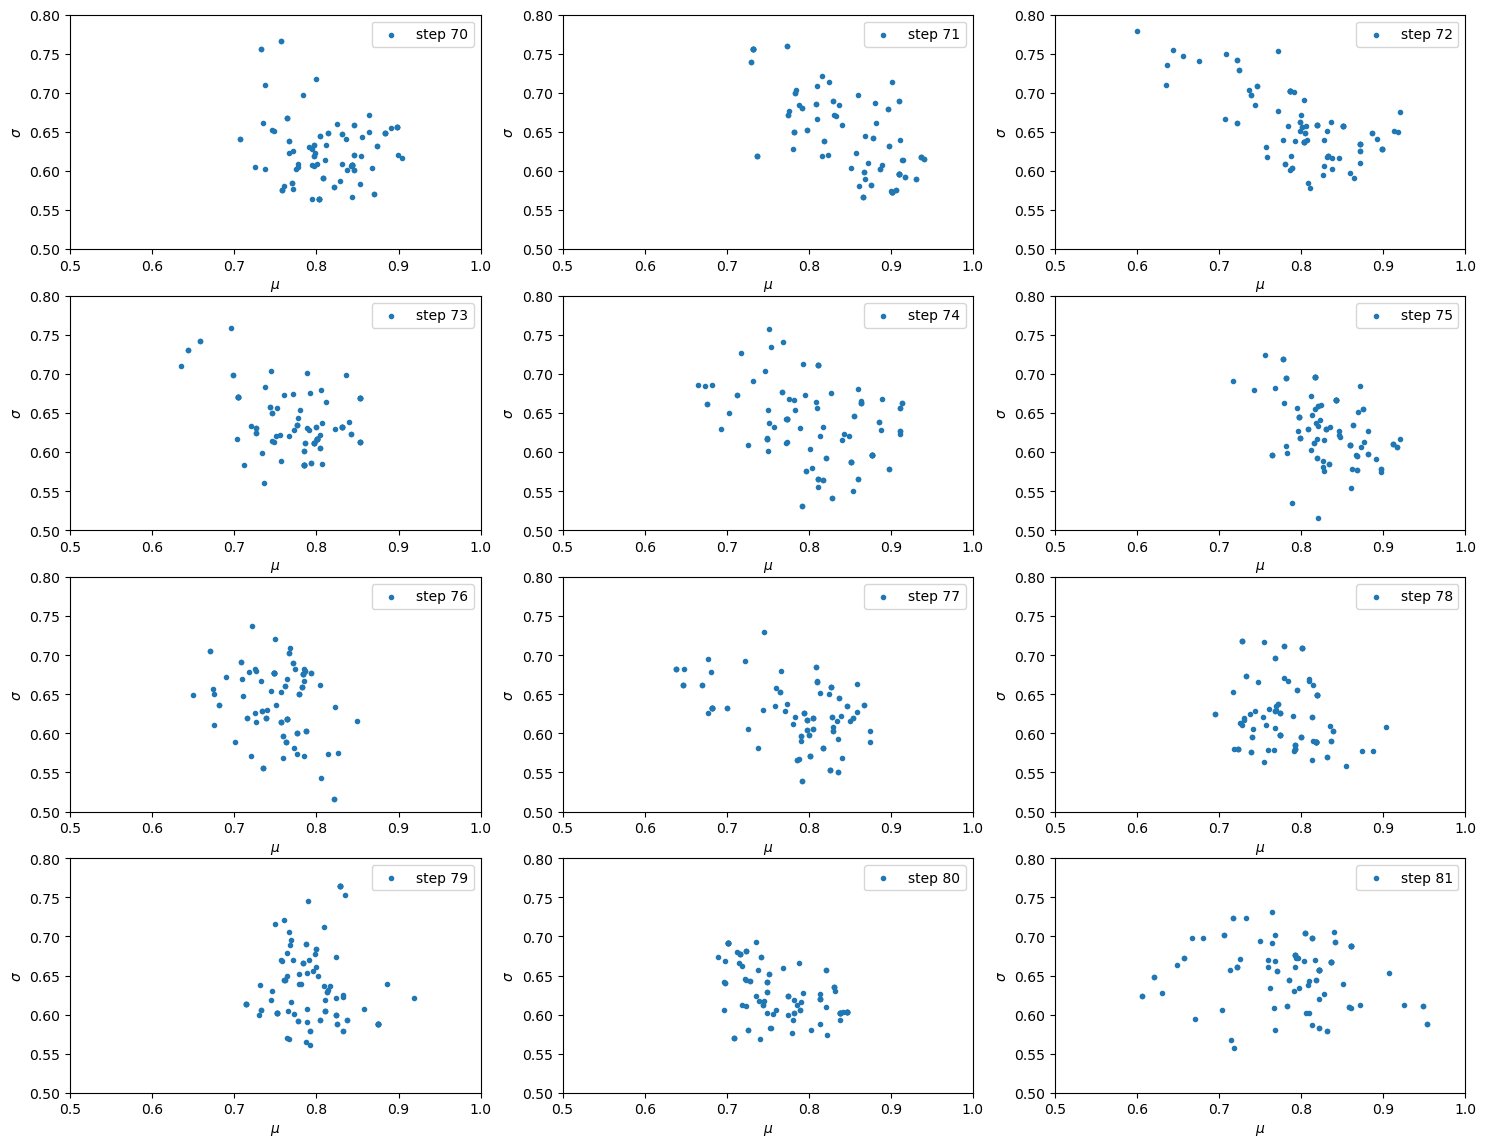

In [198]:
n = 100
steps = np.linspace(70, 81, 12, dtype=int)
fig, axx = plt.subplots(4, 3, figsize=(18, 14))
for step, ax in zip(steps, axx.flatten()):
    filename = "optimizationData/parameters_step" + str(step) + ".dat"
    res = np.loadtxt(filename, skiprows=1)
    ax.scatter(res[..., 0], res[..., 1], marker=".", label=("step " + str(step)))
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$\sigma$")
    ax.set_xlim(0.5, 1)
    ax.set_ylim(0.5, 0.8)
    ax.legend()

In [199]:
mus = []
sigmas = []
for i in range(n):
    with open("optimizationData/parameters_step" + str(i+1) + ".dat") as f:
        f.readline() #Skip 1st row
        for line in f:
            mu, sigma = map(float, line.strip().split())
            mus.append(mu)
            sigmas.append(sigma)

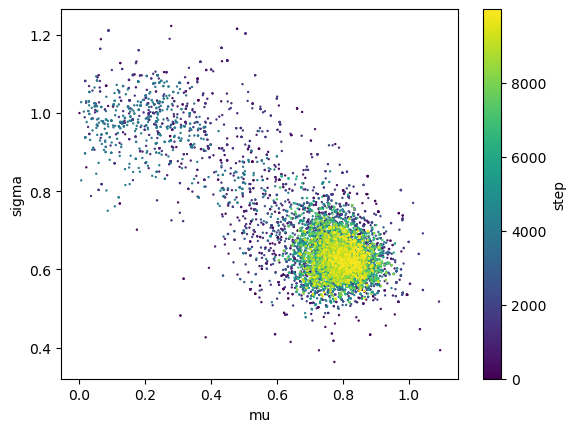

In [206]:
plt.scatter(mus, sigmas, c=list(range(len(mus))), cmap="viridis", s=0.5)
plt.xlabel("mu")
plt.ylabel("sigma")
plt.colorbar(label="step")

In [ ]:
energies = []
errors = []
for step in range(1, 101):
    filename = "optimizationData/energies_step" + str(step) + ".dat"
    with open(filename) as f:
        f.readline() #Skip 1st row
        for line in f:
            energy, error, __ = map(float, line.strip().split())
        energies.append(energy)
        errors.append(error)

In [ ]:
plt.errorbar(list(range(1, 101)), energies, yerr=errors)
plt.xlabel("step")
plt.ylabel("energia")

### Campionamento finale

In [ ]:
distro = []
Es = []
with open("final_energy_distro.dat") as f:
    mu = float(f.readline().strip())
    sigma = float(f.readline().strip())
    n_blocks = int(f.readline().strip())
    pts_per_block = int(f.readline().strip())
    for line in f:
        d, E = map(float, line.strip().split())
        distro.append(d)
        Es.append(E)

len(distro), len(Es)

In [ ]:
mu, sigma, n_blocks, pts_per_block

In [ ]:
Es = np.reshape(np.array(Es), (n_blocks, pts_per_block))
block_Es = Es.mean(axis=1)

In [ ]:
block_Es

In [ ]:
means = []
errors = []
for i in range(len(block_Es)):
    means.append(np.mean(block_Es[:i+1]))
    errors.append(np.std(block_Es[:i+1])/np.sqrt(i)) #Will nan on the 1st point, I'm fine with it

In [ ]:
mean = np.mean(block_Es)
error = np.std(block_Es, ddof=1)/np.sqrt(len(block_Es))
print(mean, "±", error)

In [ ]:
xs = np.arange(len(block_Es))
plt.errorbar(xs, means, yerr = errors, label="MCMC optimized energy")
plt.axhline(-0.460465879692715, color="red", label="matrix calculation solution")
plt.grid(True)
plt.legend()

In [ ]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

In [ ]:
norm = sp.integrate.quad(lambda x: psi2(x, mus[n-1], sigmas[n-1]), -np.inf, np.inf)

In [ ]:
# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2, label="matrix equation sol.")
plt.plot(x, psi2(x, mus[n-1], sigmas[n-1])/norm[0], label="analytical final distro")
plt.hist(distro, bins=70, density=True, histtype="step", label="sampled final distro")
plt.plot()
#plt.plot(x,(psi[1])**2)
#plt.plot(x,(psi[2])**2)
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.legend()
plt.show()